In [1]:
'''
Plot exetent/area from observations and models (past and future)
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

import esio
import esiodata as ed

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fi

In [2]:
# Plotting Info
runType = 'forecast'
variables = ['sic'] #, 'hi'
metric1 = 'extent'

In [3]:
# Initialization times to plot
cd = datetime.datetime.now()
cd = datetime.datetime(cd.year, cd.month, cd.day) # Assumes hours 00, min 00
SD = cd - datetime.timedelta(days=35)
ED = cd + datetime.timedelta(days=365)

In [4]:
# Info about models runs
# icePredicted = {'gfdlsipn':True, 'piomas':True, 'yopp':True, 'bom':False, 'cma':True, 'ecmwf':True, 
#               'hcmr':False, 'isaccnr':False, 'jma':False, 'metreofr':True, 'ukmo':True, 'eccc':False, 
#               'kma':True, 'ncep':True, 'ukmetofficesipn':True, 'ecmwfsipn':True}
# biasCorrected = 

In [5]:
#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()

In [6]:


# Load in Observations
# ds_51 = xr.open_mfdataset(E.obs['NSIDC_0051']['sipn_nc']+'/*.nc',
#                         concat_dim='time', autoclose=True, 
#                         compat='no_conflicts', data_vars=['sic','extent','area'])['extent']
# ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/*.nc', concat_dim='time', autoclose=True)
# ds_79 = xr.open_mfdataset(E.obs['NSIDC_0079']['sipn_nc']+'/*.nc',
#                         concat_dim='time', autoclose=True, 
#                         compat='no_conflicts', data_vars=['sic','extent','area'])['extent']
ds_ext = xr.open_dataset(os.path.join(E.obs['NSIDC_extent']['sipn_nc'], 'N_seaice_extent_daily_v3.0.nc'))
ds_ext = ds_ext.rename({'datetime':'time'})

In [7]:
# Combine extent obs using highest quality first
ds_obs = ds_ext #.Extent.combine_first(da_79).combine_first(da_51).combine_first(da_81)

In [8]:
# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))

# Plot Raw extents and only models that predict sea ice

gfdlsipn
Plotting...


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


21.781900038011372  seconds.
piomas
yopp
Plotting...
28.300744514912367  seconds.
cma
Plotting...
3.5555589362047613  seconds.
ecmwf
Plotting...
0.7377458293922246  seconds.
metreofr
Plotting...
0.386050283908844  seconds.
ukmo
Plotting...
3.7320102672092617  seconds.
kma
Plotting...
3.1609858172014356  seconds.
ncep
Plotting...
2.62950968882069  seconds.
ukmetofficesipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 52
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 56
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 62
  (nparts / max_parts))


Plotting...
137.0364530980587  seconds.
ecmwfsipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 25
  (nparts / max_parts))


Plotting...
250.19567280309275  seconds.
Plotting observatoins


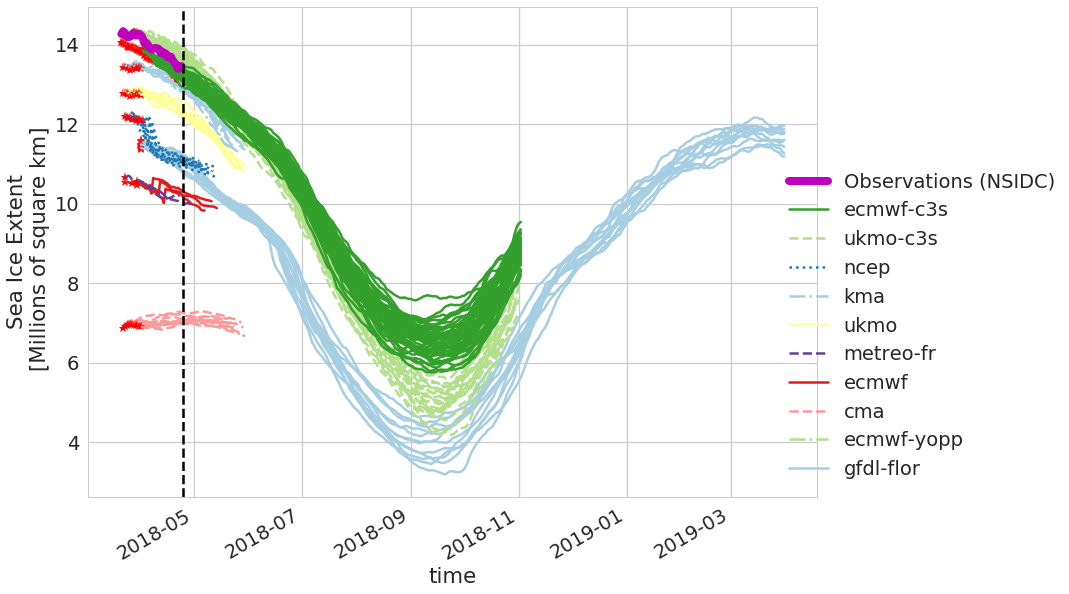

In [9]:
# cmap_c = itertools.cycle(sns.color_palette("Paired", len(E.model.keys()) ))
# linecycler = itertools.cycle(["-","--","-.",":","--"])
for cvar in variables:
    
    fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, "timeseries")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    # New Plot
    f = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(1, 1, 1) # Observations

    for (i, cmod) in enumerate(E.model.keys()):
#     for (i, cmod) in enumerate(['ukmetofficesipn']):
        
        if not E.icePredicted[cmod]:
            continue
        print(cmod)
        # Load in Model
        model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], '*.nc')

        # Check we have files 
        files = glob.glob(model_forecast)
        if not files:
            #print("Skipping model", cmod, "no forecast files found.")
            continue # Skip this model
        ds_model = xr.open_mfdataset(model_forecast, 
                                     chunks={'ensemble': 1, 'fore_time': 1, 'init_time': 1, 'nj': 304, 'ni': 448})
        ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)
#         print(ds_model)
        
        # Select var of interest (if available)
        if cvar in ds_model.variables:
            ds_model = ds_model[cvar]
        else:
            continue
        
        # Select init of interest
        ds_model = ds_model.where(ds_model.init_time>=np.datetime64(SD), drop=True)
        
        # Select last init
#         ds_model = ds_model.sel(init_time=ds_model.init_time.values[-1]).expand_dims('init_time')
#         print('only plotting last one inits')

#         Reduce to extent or area
        if metric1 == 'extent':
#             ds_model = ((ds_model >= 0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
            ds_model = esio.calc_extent(ds_model, ds_region)
        else:
            raise ValueError('Not implemented')
            
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]

        # Plot Model
        print('Plotting...')
#         print(ds_model)
        if i == 1: # Control only one initiailzation label in legend
            no_init_label = False
        else:
            no_init_label = True
        import timeit
        start_time = timeit.default_timer()
        #ds_model.load()
#         print(ds_model)
        esio.plot_reforecast(ds=ds_model, axin=ax1, 
                             labelin=E.model[cmod]['model_label'],
                             color=cc, marker=None,
                             linestyle=cl,
                             no_init_label=no_init_label)
        print( (timeit.default_timer() - start_time), ' seconds.' )
        
        # Memeory clean up
        ds_model = None
        
    # Plot observations
    print('Plotting observatoins')
    ds_obs.Extent.where(ds_obs.time>=np.datetime64(SD)).plot(ax=ax1, label='Observations (NSIDC)', color='m', linewidth=8)
    ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
    cylims = ax1.get_ylim()
    
    # Plot current date line
    ax1.plot([cd, cd], [cylims[0], cylims[1]], color='k', linestyle='--')
    
    # Add legend (static)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[::-1], labels[::-1], loc='lower right',bbox_to_anchor=(1.35, 0))
    
    f.autofmt_xdate()
    ax1.set_ylim(cylims)
    plt.subplots_adjust(right=.8)
        
    # Save to file
    f_out = os.path.join(fig_dir,'panArctic_'+metric1+'_'+runType+'_raw_predicted.png')
    f.savefig(f_out,bbox_inches='tight',dpi=200)
    mpld3.save_html(f, os.path.join(fig_dir,'panArctic_'+metric1+'_'+runType+'_raw_predicted.html'))


# Plot raw extents

gfdlsipn
Plotting...


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


21.296808165032417  seconds.
piomas
yopp
Plotting...
29.477303030434996  seconds.
bom
Plotting...
1.122859206981957  seconds.
cma
Plotting...
3.5100664938800037  seconds.
ecmwf
Plotting...
0.743001357652247  seconds.
hcmr
Plotting...
0.6246115062385798  seconds.
isaccnr
Plotting...
0.3366265227086842  seconds.
jma
Plotting...
0.35361022455617785  seconds.
metreofr
Plotting...
0.4227056261152029  seconds.
ukmo
Plotting...
3.686896513681859  seconds.
eccc
Plotting...
0.35041348822414875  seconds.
kma
Plotting...
3.0374890412203968  seconds.
ncep
Plotting...
3.080097783356905  seconds.
ukmetofficesipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 52
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 56
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 62
  (nparts / max_parts))


Plotting...
136.62978619430214  seconds.
ecmwfsipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 25
  (nparts / max_parts))


Plotting...
238.4684399748221  seconds.
Plotting observatoins


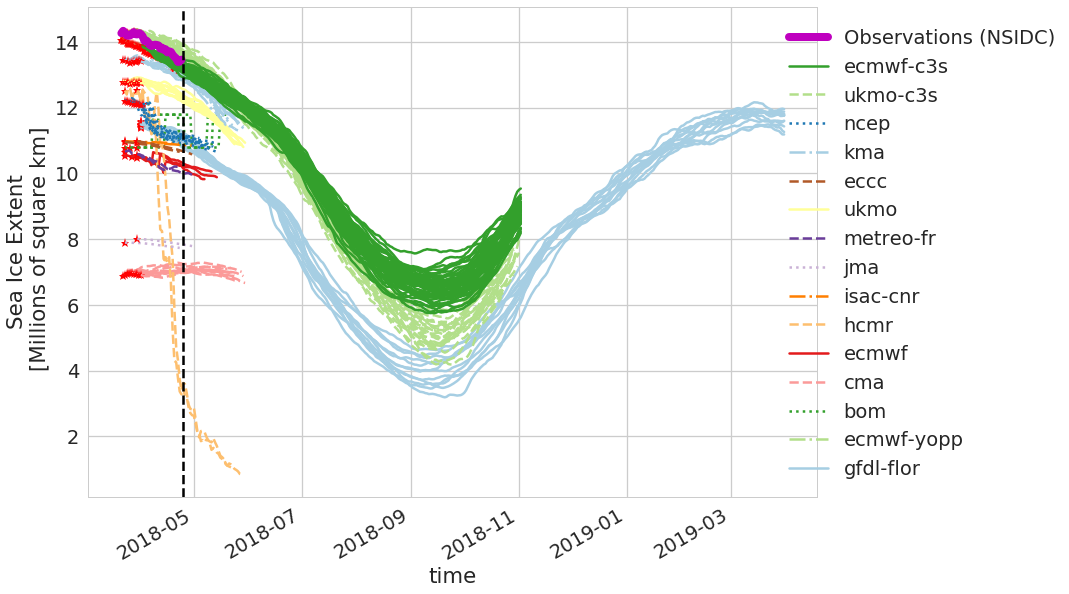

In [10]:
for cvar in variables:
    
    fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, "timeseries")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    # New Plot
    f = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(1, 1, 1) # Observations

    for (i, cmod) in enumerate(E.model.keys()):
#     for (i, cmod) in enumerate(['ukmetofficesipn']):
        print(cmod)

        # Load in Model
        model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], '*.nc')

        # Check we have files 
        files = glob.glob(model_forecast)
        if not files:
            #print("Skipping model", cmod, "no forecast files found.")
            continue # Skip this model
        ds_model = xr.open_mfdataset(model_forecast, 
                                     chunks={'ensemble': 1, 'fore_time': 1, 'init_time': 1, 'nj': 304, 'ni': 448})
        ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)
#         print(ds_model)
        
        # Select var of interest (if available)
        if cvar in ds_model.variables:
            ds_model = ds_model[cvar]
        else:
            continue
        
        # Select init of interest
        ds_model = ds_model.where(ds_model.init_time>=np.datetime64(SD), drop=True)
        
        # Select last init
#         ds_model = ds_model.sel(init_time=ds_model.init_time.values[-1]).expand_dims('init_time')
#         print('only plotting last one inits')

#         Reduce to extent or area
        if metric1 == 'extent':
#             ds_model = ((ds_model >= 0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
            ds_model = esio.calc_extent(ds_model, ds_region)
        else:
            raise ValueError('Not implemented')
            
        # Get color
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]

        # Plot Model
        print('Plotting...')
#         print(ds_model)
        if i == 1: # Control only one initiailzation label in legend
            no_init_label = False
        else:
            no_init_label = True
        import timeit
        start_time = timeit.default_timer()
        #ds_model.load()
#         print(ds_model)
        esio.plot_reforecast(ds=ds_model, axin=ax1, 
                             labelin=E.model[cmod]['model_label'],
                             color=cc, marker=None,
                             linestyle=cl,
                             no_init_label=no_init_label)
        print( (timeit.default_timer() - start_time), ' seconds.' )
        
        # Memeory clean up
        ds_model = None
        
    # Plot observations
    print('Plotting observatoins')
    ds_obs.Extent.where(ds_obs.time>=np.datetime64(SD)).plot(ax=ax1, label='Observations (NSIDC)', color='m', linewidth=8)
    ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
    cylims = ax1.get_ylim()
    
    # Plot current date line
    ax1.plot([cd, cd], [cylims[0], cylims[1]], color='k', linestyle='--')
    
    # Add legend (static)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[::-1], labels[::-1], loc='lower right',bbox_to_anchor=(1.35, 0))
    
    f.autofmt_xdate()
    ax1.set_ylim(cylims)
    plt.subplots_adjust(right=.8)
        
    # Save to file
    f_out = os.path.join(fig_dir,'panArctic_'+metric1+'_'+runType+'_raw_all.png')
    f.savefig(f_out,bbox_inches='tight',dpi=200)
    mpld3.save_html(f, os.path.join(fig_dir,'panArctic_'+metric1+'_'+runType+'_raw_all.html'))


In [11]:
# Testing memory usage

# i=0
# cmod ='ukmetofficesipn'

# # Load in Model
# model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], '*.nc')

# # Check we have files 
# files = glob.glob(model_forecast)

# ds_model = xr.open_mfdataset(model_forecast, chunks={'ensemble': 1, 'fore_time': 1, 'init_time': 1, 'nj': 304, 'ni': 448})
# ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)
# ds_model



# cvar = 'sic'
# ds_model = ds_model[cvar]

# f = plt.figure(figsize=(15,10))
# ax1 = plt.subplot(1, 1, 1) # Observations
# esio.plot_reforecast(ds=ds_model, ds_region=ds_region,
#                      axin=ax1, 
#                      labelin=E.model[cmod]['model_label'],
#                      color='r', marker=None,
#                      linestyle=next(linecycler),
#                      no_init_label=False)